# Setup

In [27]:
%%capture
import scanpy as sc
import scvi
import os
import anndata as ad
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import scrnatools as rna
import numpy as np
import warnings
import scrublet as scr

In [33]:
sc.set_figure_params(figsize=(4,4),  dpi=300, dpi_save=300, facecolor="white", frameon=False)
sns.set_context("paper")
plt.rcParams["axes.grid"] = False
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
os.getcwd()

'/home/joe/Repositories/mTEC-eTAC-atlases/mTEC-analysis'

## Set data paths

### demeter

In [4]:
rawDataPath = "/mnt/iacchus/joe/raw_data/"
processedDataPath = "/mnt/iacchus/joe/processed_data/"

### gardner-lab-computer

In [5]:
# rawDataPath = "/mnt/e/Archive/Joe/raw_data/"
# processedDataPath = "/mnt/e/Archive/Joe/processed_data/"

# Import raw data

## Fezf2

In [6]:
# WT
fezf2WTData = sc.read_10x_mtx(
    f"{rawDataPath}/Thymus/Fezf2_KO/cellranger_output/Fezf_WT/filtered_feature_bc_matrix",
    cache=True,
)
fezf2WTData.var_names_make_unique()
# Fezf2 KO
# fezf2KOData = sc.read_10x_mtx(
#     f"{rawDataPath}/Thymus/Fezf2_KO/cellranger_output/Fezf_KO/filtered_feature_bc_matrix",
#     cache=True,
# )
# fezf2KOData.var_names_make_unique()

## AireKO

In [7]:
# WT
aireWTData = sc.read_10x_mtx(
    f"{rawDataPath}Thymus/Yi_thymus/cellranger_RNA_output/2021_B6_WT",
    cache=True,
)
aireWTData.var_names_make_unique()
# Aire KO
# aireKOData = sc.read_10x_mtx(
#     f"{rawDataPath}Thymus/Yi_thymus/cellranger_RNA_output/2021_B6_KO",
#     cache=True,
# )
# aireKOData.var_names_make_unique()

## AireWT

In [8]:
# WT
wtData = sc.read_10x_h5(
    f"{rawDataPath}/Thymus/Corey_thymus/cellranger_alignment/CE/filtered_feature_bc_matrix.h5",
)
wtData.var_names_make_unique()

/conda-global-envs/single-cell-analysis/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [9]:
wtData

AnnData object with n_obs × n_vars = 9710 × 31053
    var: 'gene_ids', 'feature_types', 'genome'

# Merge data

In [10]:
adata = ad.concat(
    [fezf2WTData, aireWTData, wtData],
    label="batch",
    keys=["WT_1", "WT_2", "WT_3"],
)
adata.obs_names_make_unique()
adata.layers["counts"] = adata.X.copy()

/conda-global-envs/single-cell-analysis/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [11]:
adata.obs["genotype"] = [i.rsplit("_", 1)[0] for i in adata.obs.batch]
adata.obs["experiment"] = [i.rsplit("_", 1)[1] for i in adata.obs.batch]

# Scrublet doublet removal

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.60
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.0%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 0.0%
Elapsed time: 8.8 seconds
Detected doublet rate = 0.4%
Estimated detectable doublet fraction = 5.5%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 8.0%
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.46
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.0%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 57.1%
Elapsed time: 7.7 seconds
Detected doublet rate = 0.4%
Estimated detectable doublet fraction = 2.6%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 15.4%
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating 

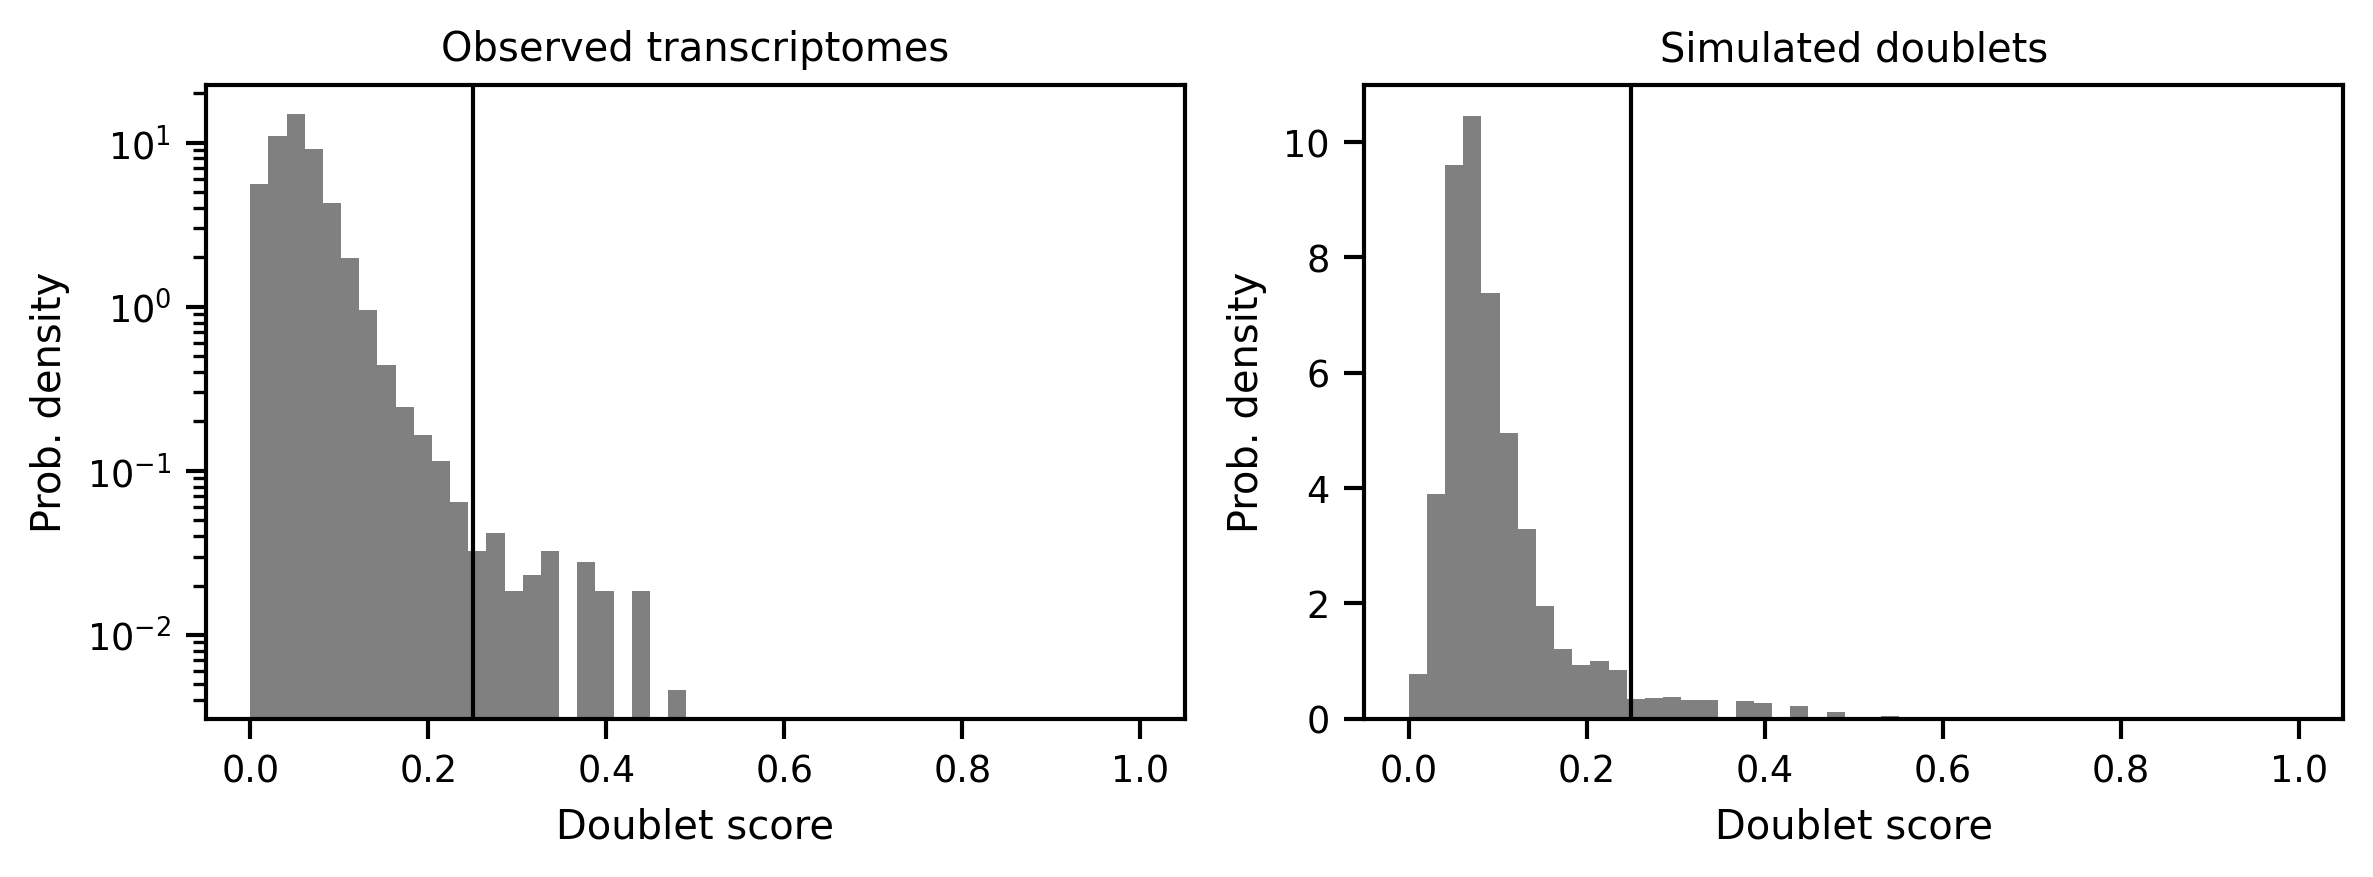

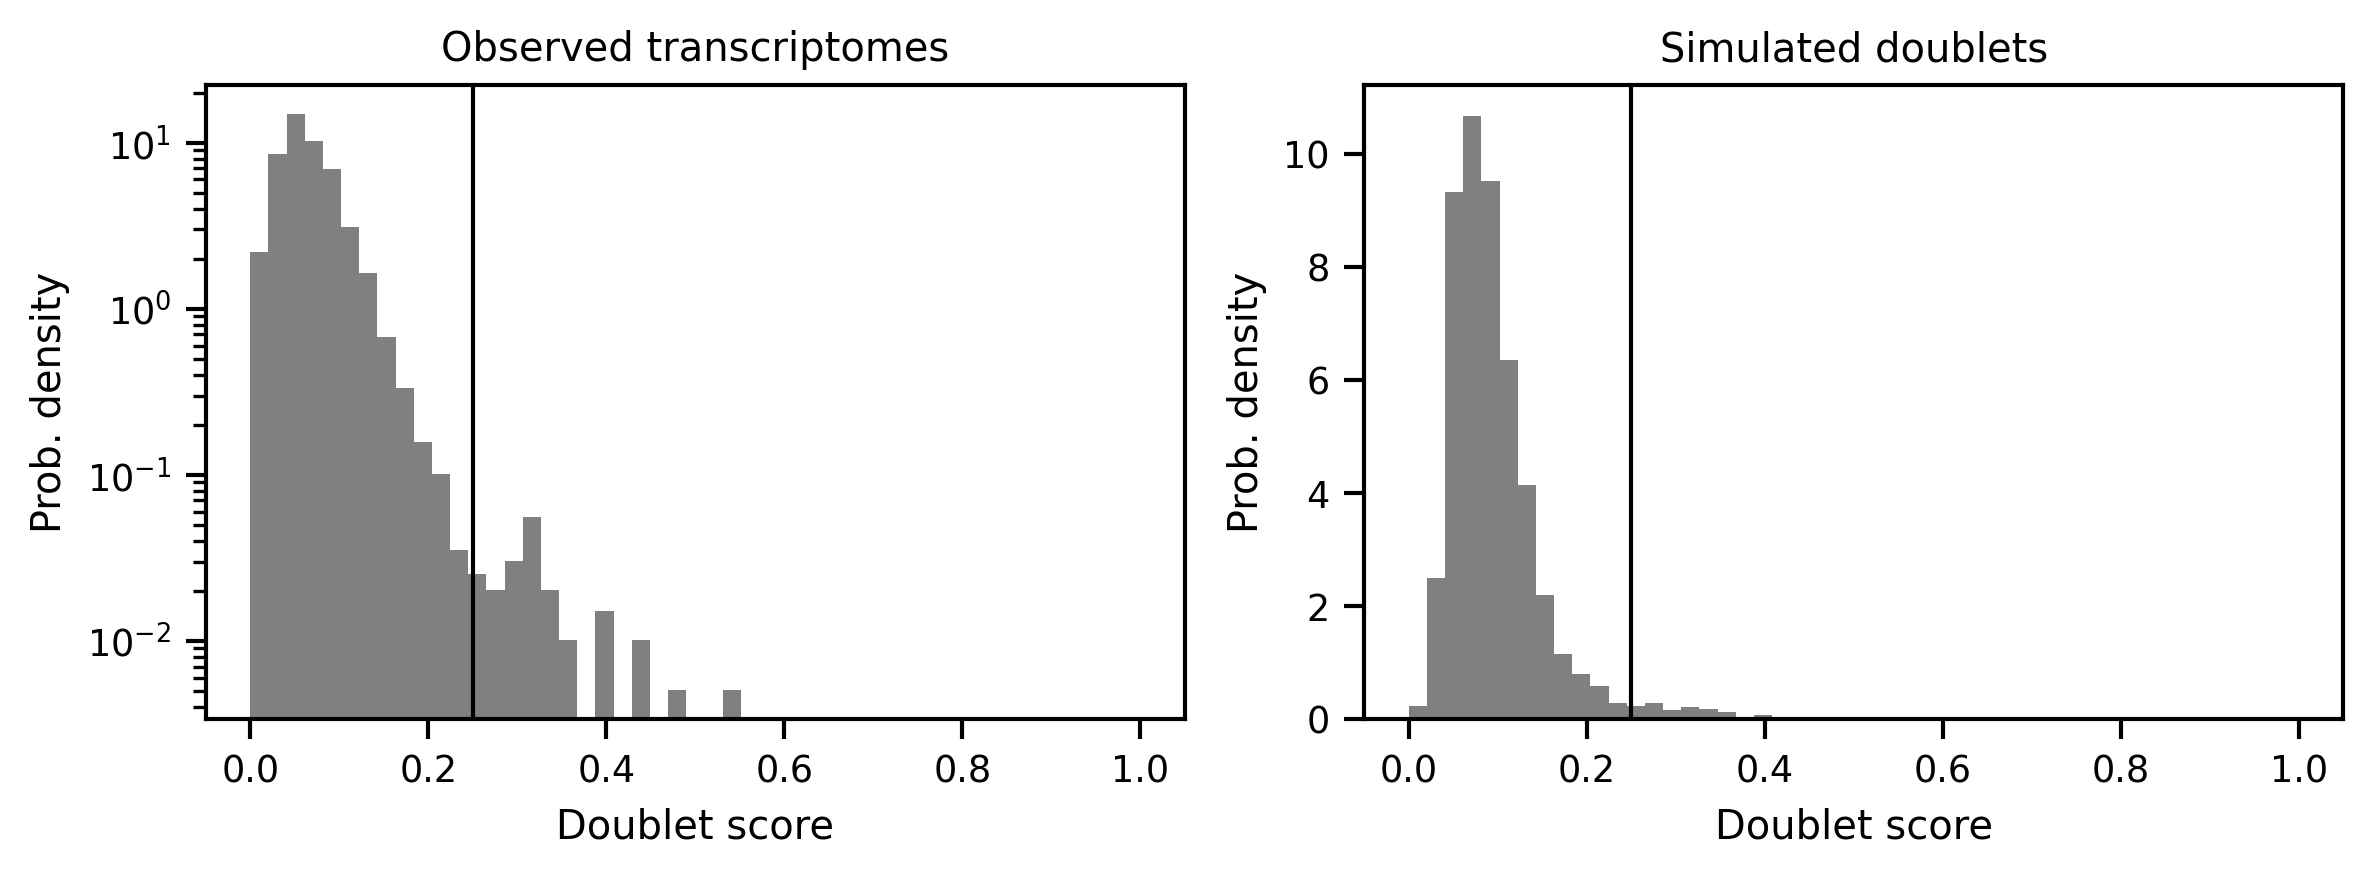

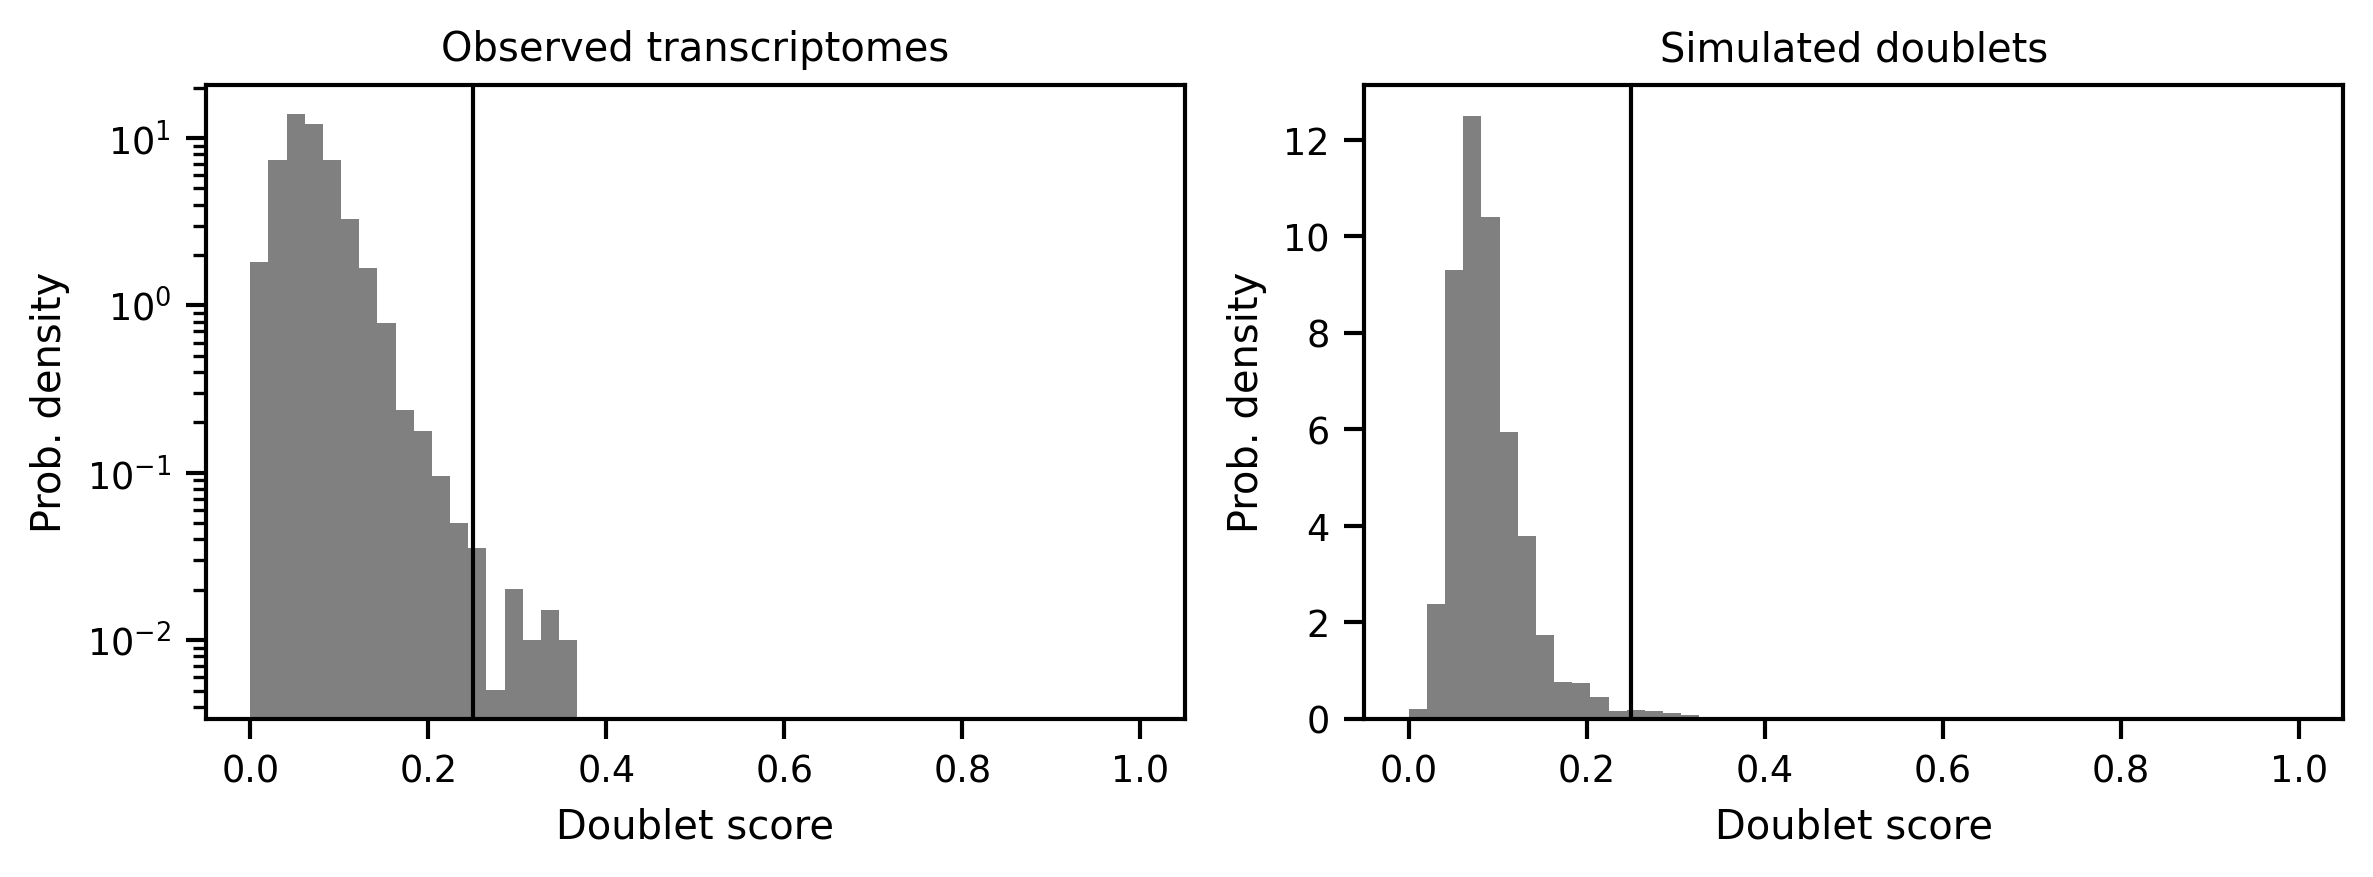

In [12]:
doublet_threshold = 0.25

scrubletPredictions = pd.DataFrame()
for key in adata.obs.batch.unique():
    subsetData = adata[adata.obs.batch == key]
    counts_matrix = subsetData.layers["counts"]
    scrub = scr.Scrublet(counts_matrix, expected_doublet_rate=0.06)
    doublet_scores, predicted_doublets = scrub.scrub_doublets(
        min_counts=2, 
        min_cells=3, 
        min_gene_variability_pctl=85, 
        n_prin_comps=30
    )
    scrub.call_doublets(threshold=doublet_threshold)
    scrub.plot_histogram()
    scrubletPrediction = pd.DataFrame({"scrublet_score": doublet_scores}, index=subsetData.obs.index)
    scrubletPredictions = pd.concat([scrubletPredictions, scrubletPrediction])
    
adata.obs["scrublet_score"] = scrubletPredictions.scrublet_score
adata.obs["scrublet_called_doublet"] = adata.obs.scrublet_score > doublet_threshold
num_doublets = adata.obs.scrublet_called_doublet.sum()
pct_doublets = round(num_doublets/len(adata)*100, 3)
print(f"{pct_doublets}% of cells classified as doublets ({num_doublets} cells)")

In [13]:
adata = adata[~adata.obs.scrublet_called_doublet]

# Preprocessing

In [14]:
# Annotate mito genes
adata.var["mt"] = adata.var_names.str.startswith("mt-")
# Get qc metrics for each cell, gene
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True, percent_top=None, log1p=False,)
# Basic prefiltering of empty cells, 0 counts genes
sc.pp.filter_cells(adata, min_genes=1)
sc.pp.filter_genes(adata, min_cells=1)

/tmp/ipykernel_381996/2029572420.py:2: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["mt"] = adata.var_names.str.startswith("mt-")


## QC filter

In [15]:
# Helper method for plotting QC metrics for scrnaseq package
def qc_plot(adata, counts_thresh=30000, genes_thresh=5000, mt_thresh=10, show_thresh=True, save_path=None):
    sns.set_style("ticks")
    sns.set_context("paper")
    fig=plt.figure(figsize=(9,3))
    plt.subplot(1,3,1)
    sns.histplot(
        x=adata.obs.pct_counts_mt,
        hue=adata.obs.batch,
    )
    if show_thresh:
        plt.axvline(
            x=mt_thresh,
            ymin=0,
            ymax=1,
            color="black",
            linestyle="--",
        )

    plt.subplot(1,3,2)
    sns.scatterplot(
        x=adata.obs.total_counts,
        y=adata.obs.n_genes_by_counts,
        s=2,
        hue=adata.obs.batch,
        linewidth=0,
    )
    if show_thresh:
        plt.axvline(
            x=counts_thresh,
            ymin=0,
            ymax=1,
            color="black",
            linestyle="--",
        )
        plt.axhline(
            y=genes_thresh,
            xmin=0,
            xmax=1,
            color="black",
            linestyle="--",
        )
    plt.subplot(1,3,3)
    cell_data = pd.DataFrame()
    for category in adata.obs.batch.unique():
        category_data = adata[adata.obs.batch == category].obs.copy()
        category_data["rank"] = category_data.total_counts.rank(method="first", ascending=False,)
        cell_data = pd.concat([cell_data, category_data])
    cell_data = cell_data.sort_values(by="rank")
    ax =sns.lineplot(
        x=cell_data["rank"],
        y=cell_data.total_counts,
        hue=cell_data.batch,
        hue_order=adata.obs.batch.unique(),
    )
    ax.set(yscale="log")
    ax.set(xscale="log")
    if show_thresh:
        plt.axhline(
            y=counts_thresh,
            xmin=0,
            xmax=1,
            color="black",
            linestyle="--",
        )
    fig.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, dpi=300)
    plt.show()

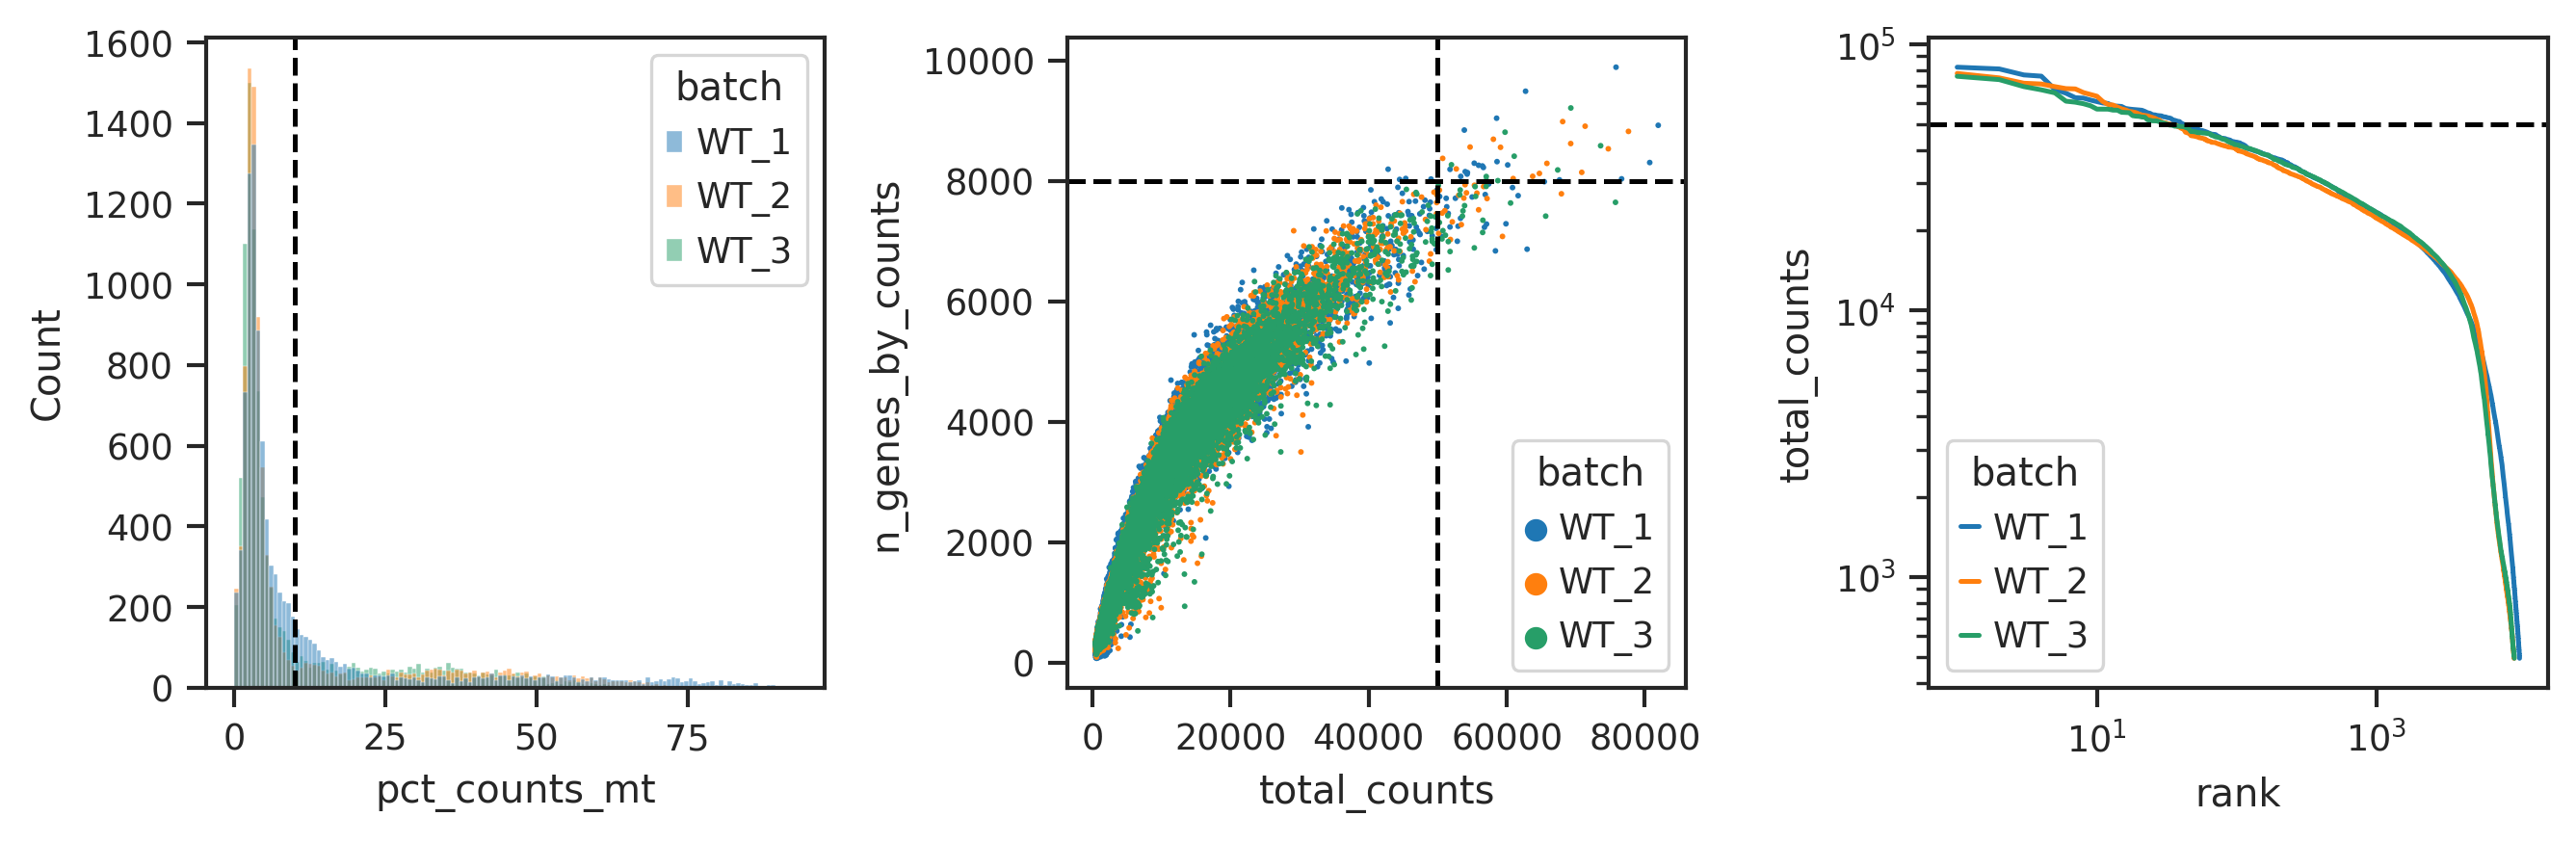

In [16]:
# save a copy of the unfiltered data
adataUnfiltered = adata.copy()

# Set thresholds
totalCountsThreshold = 50000
numGenesThreshold = 8000
mtThreshold = 10

# Check QC thresholds before filtering
qc_plot(adata, totalCountsThreshold, numGenesThreshold, mtThreshold)

In [17]:
# Filter cells based on thresholds
adataFiltered = adata[adata.obs.pct_counts_mt <= mtThreshold].copy()
adataFiltered = adataFiltered[adataFiltered.obs.total_counts <= totalCountsThreshold]
adataFiltered = adataFiltered[adataFiltered.obs.total_counts >= 5000]
adataFiltered = adataFiltered[adataFiltered.obs.n_genes_by_counts <= numGenesThreshold]
adataFiltered = adataFiltered[adataFiltered.obs.n_genes_by_counts >= 2000]

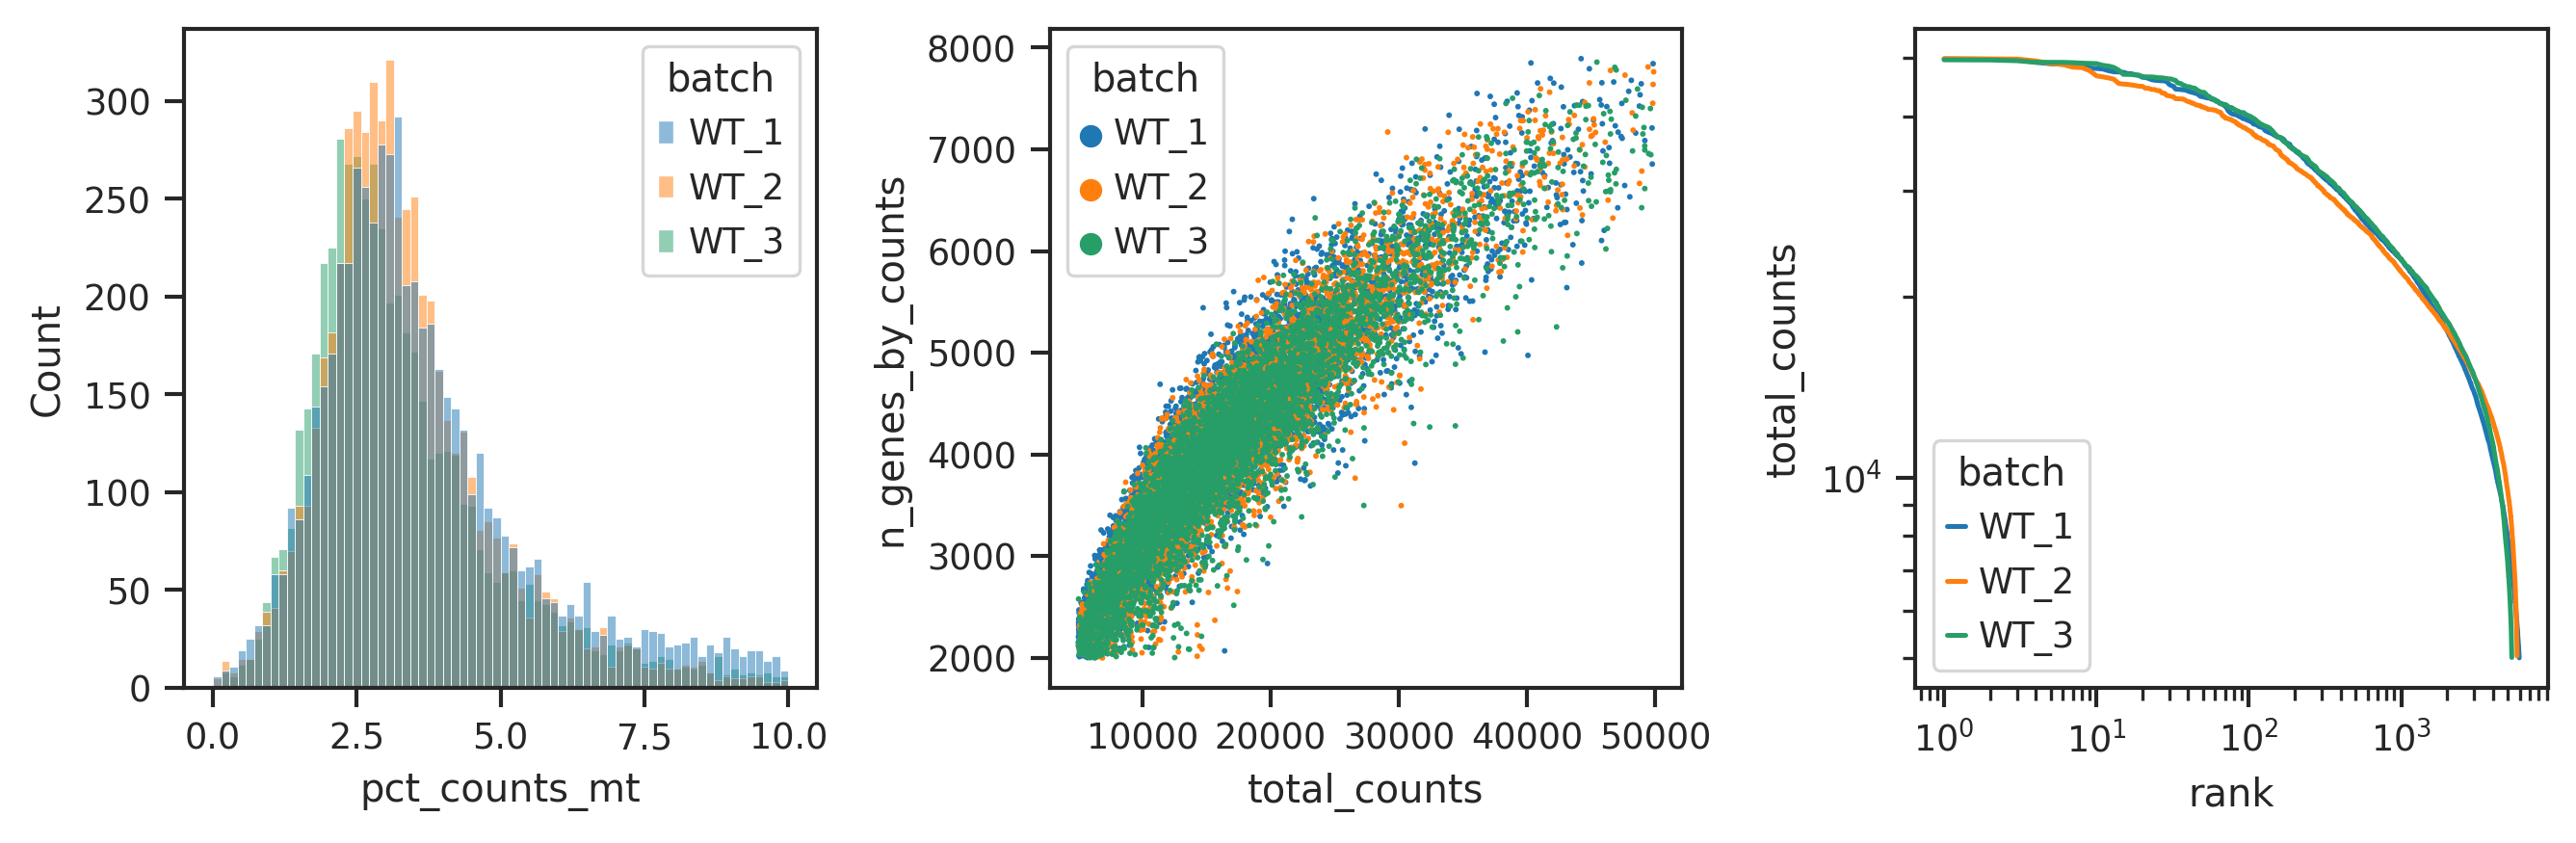

In [19]:
qc_plot(
    adataFiltered,
    show_thresh=False,
)

In [20]:
# overwrite original adata variable with the filtered data
adata = adataFiltered

# Clean up to save memory 
del adataFiltered

## Normalize data (scanpy)

In [21]:
# Scanpy preprocessing pipeline
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata # Preserve log-transformed counts in the raw attribute

/conda-global-envs/single-cell-analysis/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [22]:
adata

AnnData object with n_obs × n_vars = 17026 × 27948
    obs: 'batch', 'genotype', 'experiment', 'scrublet_score', 'scrublet_called_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'log1p'
    layers: 'counts'

# scVI training

In [23]:
# Setup scVI model using raw counts and batch info
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
    batch_key="batch",
)
model = scvi.model.SCVI(adata)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [24]:
# Train scVI model
model.train()

Epoch 400/400: 100%|██████████| 400/400 [06:06<00:00,  1.09it/s, loss=1.14e+04, v_num=1]


In [25]:
# get scVI latent space and normalized expression
adata.obsm["X_scVI"] = model.get_latent_representation()
adata.layers["scVI_normalized"] = model.get_normalized_expression(library_size=1e4)

In [35]:
# Checl save paths
if not os.path.isdir(f"{processedDataPath}/mTEC_analysis/scVI_models"):
    os.makedirs(f"{processedDataPath}/mTEC_analysis/scVI_models/")
    
if not os.path.isdir(f"{processedDataPath}/mTEC_analysis/h5ad_files/"):
    os.makedirs(f"{processedDataPath}/mTEC_analysis/h5ad_files/")
    
if os.path.isdir(f"{processedDataPath}/mTEC_analysis/scVI_models/combined_WT_all_genes"):
    shutil.rmtree(f"{processedDataPath}/mTEC_analysis/scVI_models/combined_WT_all_genes")
    
# save the scVI model and adata object before further processing because training is non-deterministic
model.save(f"{processedDataPath}/mTEC_analysis/scVI_models/combined_WT_all_genes")
adata.write(f"{processedDataPath}/mTEC_analysis/h5ad_files/combined_WT_all_genes.h5ad")

# Dimensionality reduction

In [19]:
adata = sc.read(f"{processedDataPath}/mTEC_analysis/h5ad_files/combined_WT_all_genes.h5ad")

In [26]:
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.25,)

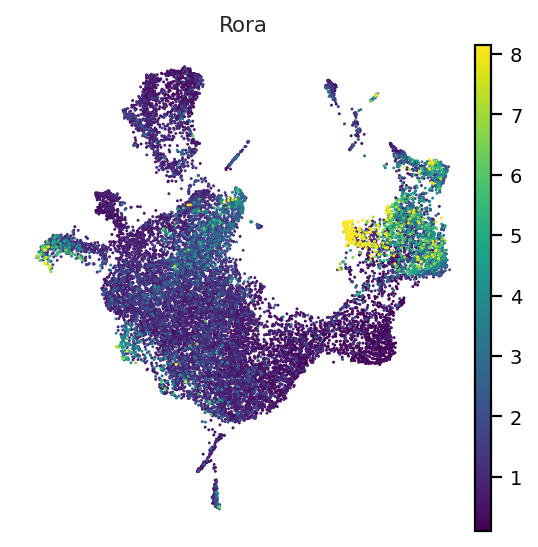

In [34]:
rna.pl.gene_embedding(
    adata,
    gene_list=["Rora"],
    layer="scVI_normalized",
    cmap="viridis"
)

/conda-global-envs/single-cell-analysis/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


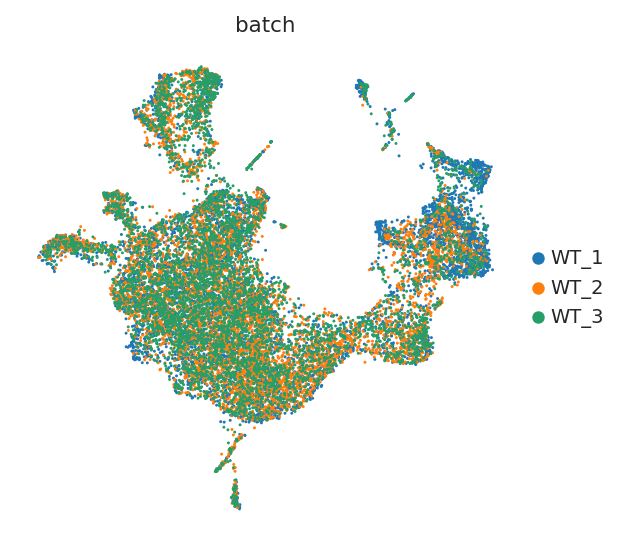

In [35]:
sc.pl.umap(
    adata,
    color=["batch"]
)

In [36]:
adata.obs.batch.value_counts()

WT_1    5950
WT_2    5761
WT_3    5315
Name: batch, dtype: int64

In [37]:
sc.tl.embedding_density(adata, basis='umap', groupby='batch')

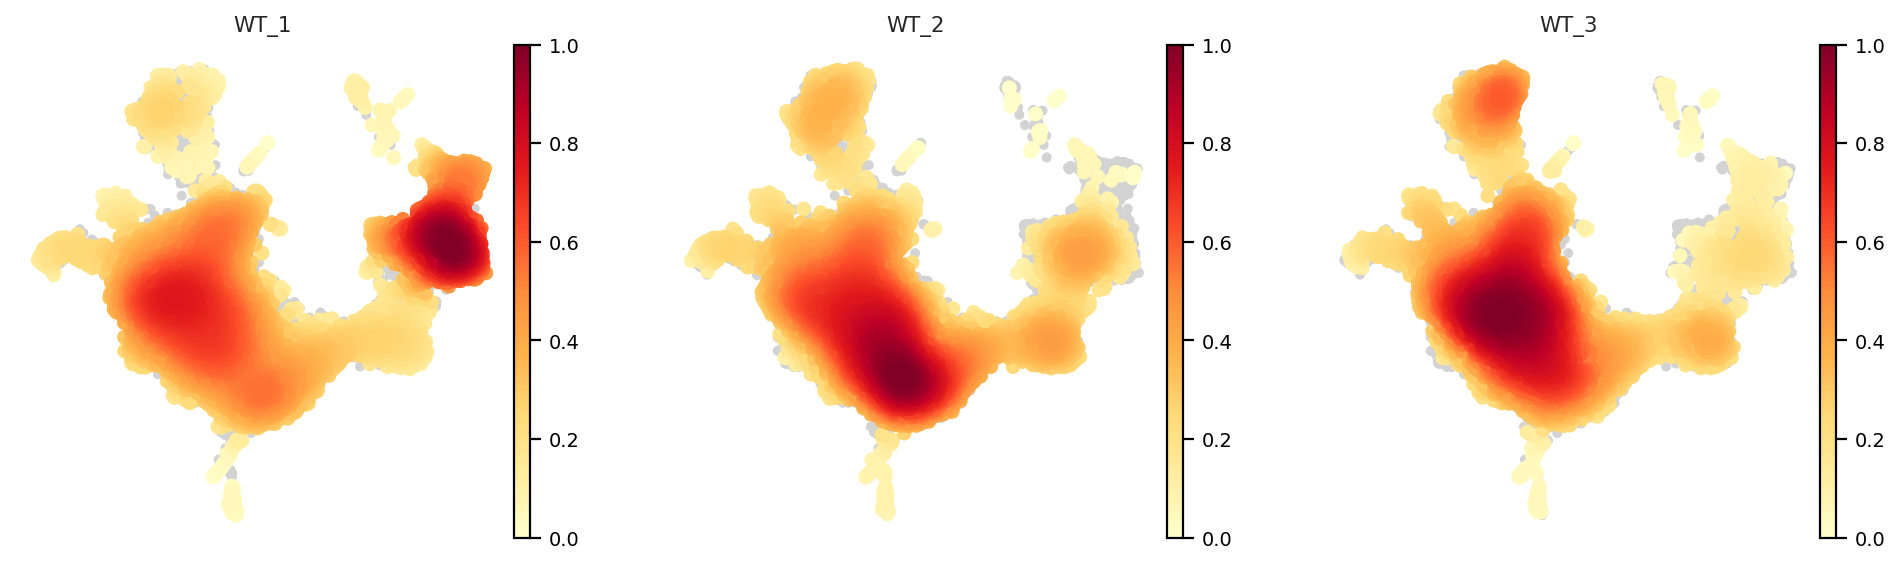

In [38]:
sc.pl.embedding_density(adata, basis='umap', key='umap_density_batch')